In this notebook, we'll implement a trainable GNN model based on our understanding of information diffusion. We'll focus on how to train the parameters of transition and output functions using gradient-based optimization.

## 1. Introduction to GNN Training

In the previous notebooks, we explored how information diffuses through a graph structure using fixed transition functions. Now, we'll learn how to train these functions to solve specific tasks.

A trainable GNN consists of two main components:
1. A **parameterized transition function** that updates node states
2. A **parameterized output function** that produces the final output for each node

The parameters of these functions are trained using gradient-based optimization, similar to other neural networks.

## 2. Implementing a Trainable GNN in PyTorch

Let's implement a trainable GNN using PyTorch. We'll define our model to be flexible enough for both node-level and graph-level tasks.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class GNNLayer(nn.Module):
    """
    A single layer of a Graph Neural Network.
    
    This implements the parameterized transition function that updates node states
    based on their features and the states of their neighbors.
    """
    def __init__(self, node_dim, state_dim, edge_dim=0, hidden_dim=32):
        """
        Initialize the GNN layer.
        
        Args:
            node_dim: Dimension of node features
            state_dim: Dimension of state vectors
            edge_dim: Dimension of edge features (optional)
            hidden_dim: Dimension of hidden layers in MLPs
        """
        super(GNNLayer, self).__init__()
        
        # Dimensions
        self.node_dim = node_dim
        self.state_dim = state_dim
        self.edge_dim = edge_dim
        
        # MLP for processing node's own features and state
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # MLP for processing neighbor states and features
        self.neighbor_mlp = nn.Sequential(
            nn.Linear(state_dim + node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Final combination MLP
        self.combine_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )
        
        # Parameter to control how much of the previous state is retained
        self.alpha = nn.Parameter(torch.tensor(0.1))
        
        # Initialize weights to ensure contraction
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights to ensure the contraction property."""
        # Small initial weights help ensure the contraction property
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight, gain=0.1)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, node_features, states, edge_index, edge_features=None):
        """
        Update node states using the transition function.
    
        Args:
            node_features: Tensor of node features [num_nodes, node_dim]
            states: Tensor of current node states [num_nodes, state_dim]
            edge_index: Tensor of edge indices [2, num_edges]
            edge_features: Tensor of edge features [num_edges, edge_dim] (optional)
        
        Returns:
            New state tensor [num_nodes, state_dim]
        """
        num_nodes = node_features.size(0)
    
        # Process node's own features and state
        own_info = torch.cat([node_features, states], dim=1)
        own_embedding = self.node_mlp(own_info)
    
        # Process messages from neighbors
        src, dst = edge_index
    
        # Initialize container for neighbor messages
        # Use hidden_dim instead of trying to access out_features from Sequential
        hidden_dim = own_embedding.size(1)  # Get dimension from the output of node_mlp
        neighbor_embeddings = torch.zeros(num_nodes, hidden_dim, device=node_features.device)
    
        # Prepare messages for each edge
        if edge_features is not None:
            messages = torch.cat([states[src], node_features[src], edge_features], dim=1)
        else:
            messages = torch.cat([states[src], node_features[src]], dim=1)
    
        # Process messages
        messages = self.neighbor_mlp(messages)
    
        # Aggregate messages for each node (mean pooling)
        neighbor_embeddings.index_add_(0, dst, messages)
        node_counts = torch.zeros(num_nodes, 1, device=node_features.device)
        node_counts.index_add_(0, dst, torch.ones(src.size(0), 1, device=node_features.device))
        node_counts = torch.clamp(node_counts, min=1)  # Avoid division by zero
        neighbor_embeddings = neighbor_embeddings / node_counts
    
        # Combine own information with neighbor information
        combined = torch.cat([own_embedding, neighbor_embeddings], dim=1)
        state_update = self.combine_mlp(combined)
    
        # Update state (with residual connection)
        # Using sigmoid(alpha) ensures the coefficient is between 0 and 1
        alpha = torch.sigmoid(self.alpha)
        new_states = (1 - alpha) * states + alpha * state_update
    
        return new_states

class GNN(nn.Module):
    """
    Full Graph Neural Network model.
    
    This combines multiple GNN layers with an output function.
    """
    def __init__(self, node_dim, state_dim, output_dim, edge_dim=0, hidden_dim=32, 
                 num_layers=3, max_iterations=10, threshold=1e-6):
        """
        Initialize the GNN model.
        
        Args:
            node_dim: Dimension of node features
            state_dim: Dimension of state vectors
            output_dim: Dimension of output vectors
            edge_dim: Dimension of edge features (optional)
            hidden_dim: Dimension of hidden layers in MLPs
            num_layers: Number of GNN layers
            max_iterations: Maximum number of iterations for state updates
            threshold: Convergence threshold for state updates
        """
        super(GNN, self).__init__()
        
        # Model parameters
        self.node_dim = node_dim
        self.state_dim = state_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.max_iterations = max_iterations
        self.threshold = threshold
        
        # GNN layers
        self.layers = nn.ModuleList([
            GNNLayer(node_dim, state_dim, edge_dim, hidden_dim)
            for _ in range(num_layers)
        ])
        
        # Output function (Fw in the paper)
        self.output_function = nn.Sequential(
            nn.Linear(state_dim + node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights for the output function."""
        for module in self.output_function.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, node_features, edge_index, edge_features=None, 
                initial_states=None, return_states=False):
        """
        Forward pass through the GNN.
        
        Args:
            node_features: Tensor of node features [num_nodes, node_dim]
            edge_index: Tensor of edge indices [2, num_edges]
            edge_features: Tensor of edge features [num_edges, edge_dim] (optional)
            initial_states: Initial node states [num_nodes, state_dim] (optional)
            return_states: Whether to return the final states along with outputs
            
        Returns:
            Node outputs [num_nodes, output_dim]
            (and optionally final states)
        """
        num_nodes = node_features.size(0)
        
        # Initialize states if not provided
        if initial_states is None:
            states = torch.zeros(num_nodes, self.state_dim, device=node_features.device)
        else:
            states = initial_states
        
        # Keep track of state history for visualization
        state_history = [states.clone().detach()]
        
        # Iterate through layers until convergence or max iterations
        for layer_idx in range(self.num_layers):
            layer = self.layers[layer_idx]
            
            for iteration in range(self.max_iterations):
                new_states = layer(node_features, states, edge_index, edge_features)
                
                # Check convergence
                delta = torch.norm(new_states - states, dim=1).max().item()
                states = new_states
                
                # Save state for visualization
                if return_states:
                    state_history.append(states.clone().detach())
                
                if delta < self.threshold:
                    break
        
        # Apply output function to final states
        combined = torch.cat([states, node_features], dim=1)
        outputs = self.output_function(combined)
        
        if return_states:
            return outputs, state_history
        else:
            return outputs
    
    def predict_graph_level(self, node_features, edge_index, edge_features=None, 
                           initial_states=None, pooling='mean'):
        """
        Make predictions at the graph level by pooling node outputs.
        
        Args:
            node_features: Tensor of node features [num_nodes, node_dim]
            edge_index: Tensor of edge indices [2, num_edges]
            edge_features: Tensor of edge features [num_edges, edge_dim] (optional)
            initial_states: Initial node states [num_nodes, state_dim] (optional)
            pooling: Pooling method ('mean', 'max', or 'sum')
            
        Returns:
            Graph-level output [output_dim]
        """
        # Get node-level outputs
        node_outputs = self.forward(node_features, edge_index, edge_features, initial_states)
        
        # Pool node outputs to get graph-level output
        if pooling == 'mean':
            return torch.mean(node_outputs, dim=0)
        elif pooling == 'max':
            return torch.max(node_outputs, dim=0)[0]
        elif pooling == 'sum':
            return torch.sum(node_outputs, dim=0)
        else:
            raise ValueError(f"Unknown pooling method: {pooling}")

## 3. Data Preparation for GNN Training

Before training, we need to convert our graph data into a format suitable for PyTorch. Let's create utility functions for this task:

In [6]:
def convert_networkx_to_pytorch(graph, node_features=None, edge_features=None, device=None):
    """
    Convert a NetworkX graph to PyTorch tensors.
    
    Args:
        graph: NetworkX graph
        node_features: Dictionary mapping node IDs to feature tensors (optional)
        edge_features: Dictionary mapping (src, dst) tuples to feature tensors (optional)
        device: PyTorch device
        
    Returns:
        Dictionary with 'node_features', 'edge_index', and 'edge_features' tensors
    """
    # Convert node indices to consecutive integers if they aren't already
    graph = nx.convert_node_labels_to_integers(graph)
    
    # Create edge index tensor
    edges = list(graph.edges())
    edge_index = torch.tensor([[src, dst] for src, dst in edges], dtype=torch.long).t()
    
    # Add reverse edges for undirected graphs
    if not graph.is_directed():
        edge_index_reverse = torch.tensor([[dst, src] for src, dst in edges], dtype=torch.long).t()
        edge_index = torch.cat([edge_index, edge_index_reverse], dim=1)
    
    # Process node features
    if node_features is None:
        # Use degree as default feature
        node_features = torch.tensor(
            [[graph.degree(node)] for node in range(len(graph.nodes()))],
            dtype=torch.float
        )
    elif isinstance(node_features, dict):
        # Convert dictionary to tensor
        node_features = torch.stack([
            node_features.get(node, torch.zeros(1)) 
            for node in range(len(graph.nodes()))
        ])
    
    # Process edge features
    if edge_features is not None and isinstance(edge_features, dict):
        # Convert dictionary to tensor
        edge_features_list = []
        for src, dst in edges:
            feat = edge_features.get((src, dst), torch.zeros(1))
            edge_features_list.append(feat)
        
        # Add features for reverse edges if graph is undirected
        if not graph.is_directed():
            for src, dst in edges:
                feat = edge_features.get((dst, src), edge_features.get((src, dst), torch.zeros(1)))
                edge_features_list.append(feat)
        
        edge_features = torch.stack(edge_features_list)
    
    # Move to device if specified
    if device is not None:
        node_features = node_features.to(device)
        edge_index = edge_index.to(device)
        if edge_features is not None:
            edge_features = edge_features.to(device)
    
    return {
        'node_features': node_features,
        'edge_index': edge_index,
        'edge_features': edge_features
    }

def prepare_dataset(graphs, node_features_list=None, edge_features_list=None, labels=None, device=None):
    """
    Prepare a dataset of multiple graphs for training.
    
    Args:
        graphs: List of NetworkX graphs
        node_features_list: List of node feature dictionaries (optional)
        edge_features_list: List of edge feature dictionaries (optional)
        labels: List of graph labels (optional)
        device: PyTorch device
        
    Returns:
        List of dictionaries with graph data and labels
    """
    dataset = []
    
    for i, graph in enumerate(graphs):
        # Get features for this graph
        node_features = None if node_features_list is None else node_features_list[i]
        edge_features = None if edge_features_list is None else edge_features_list[i]
        
        # Convert graph to PyTorch format
        data = convert_networkx_to_pytorch(graph, node_features, edge_features, device)
        
        # Add label if provided
        if labels is not None:
            data['label'] = labels[i]
            if device is not None:
                data['label'] = data['label'].to(device)
        
        dataset.append(data)
    
    return dataset

## 4. Training the GNN for Node Classification

Let's demonstrate how to train a GNN for a node classification task. We'll create a simple synthetic dataset for this purpose:

In [7]:
def create_synthetic_node_classification_dataset(num_graphs=10, min_nodes=10, max_nodes=20, 
                                               num_classes=3, feature_dim=5, seed=42):
    """
    Create a synthetic dataset for node classification.
    
    Args:
        num_graphs: Number of graphs in the dataset
        min_nodes: Minimum number of nodes per graph
        max_nodes: Maximum number of nodes per graph
        num_classes: Number of node classes
        feature_dim: Dimension of node features
        seed: Random seed
        
    Returns:
        List of graphs, node features, and node labels
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    graphs = []
    node_features_list = []
    node_labels_list = []
    
    for _ in range(num_graphs):
        # Determine number of nodes
        num_nodes = np.random.randint(min_nodes, max_nodes + 1)
        
        # Create a random graph
        p = 0.3  # Edge probability
        graph = nx.erdos_renyi_graph(num_nodes, p, seed=seed)
        
        # Ensure graph is connected
        if not nx.is_connected(graph):
            # Get the largest connected component
            largest_cc = max(nx.connected_components(graph), key=len)
            graph = graph.subgraph(largest_cc).copy()
        
        # Create node features (random)
        node_features = {}
        for node in graph.nodes():
            # Random features
            features = torch.randn(feature_dim)
            node_features[node] = features
        
        # Assign labels based on node degree and features
        node_labels = {}
        for node in graph.nodes():
            # Combine degree and first feature to determine class
            degree = graph.degree(node)
            feature_val = node_features[node][0].item()
            
            # Simple rule for assigning class
            score = degree + feature_val
            label = int(score) % num_classes
            
            node_labels[node] = torch.tensor(label, dtype=torch.long)
        
        graphs.append(graph)
        node_features_list.append(node_features)
        node_labels_list.append(node_labels)
    
    return graphs, node_features_list, node_labels_list

# Create synthetic dataset
graphs, node_features_list, node_labels_list = create_synthetic_node_classification_dataset()

# Split into train/test
num_graphs = len(graphs)
train_idx = int(0.8 * num_graphs)

train_graphs = graphs[:train_idx]
train_node_features = node_features_list[:train_idx]
train_node_labels = node_labels_list[:train_idx]

test_graphs = graphs[train_idx:]
test_node_features = node_features_list[train_idx:]
test_node_labels = node_labels_list[train_idx:]

print(f"Created dataset with {len(train_graphs)} training graphs and {len(test_graphs)} test graphs")

Created dataset with 8 training graphs and 2 test graphs


Now, let's implement the training procedure:

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.9504
Epoch 20/50, Loss: 0.7741
Epoch 30/50, Loss: 0.6557
Epoch 40/50, Loss: 0.5506
Epoch 50/50, Loss: 0.4770


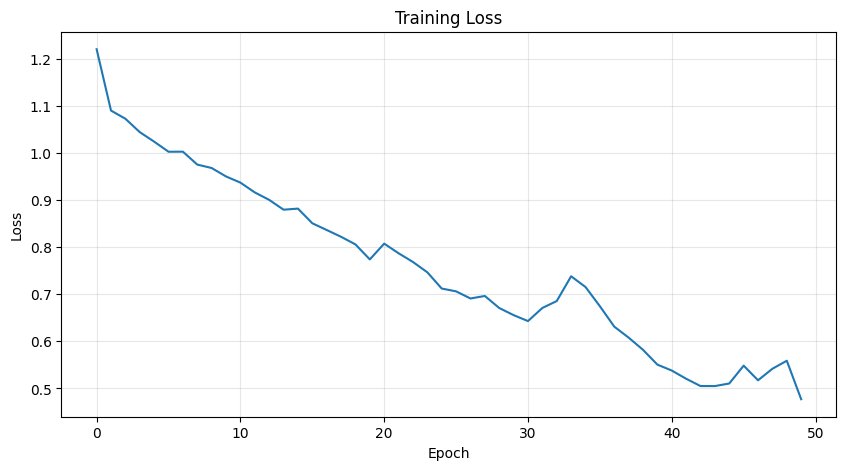

Test accuracy: 0.2500


In [8]:
def train_node_classification(model, train_graphs, train_node_features, train_node_labels, 
                             num_epochs=100, learning_rate=0.01):
    """
    Train a GNN model for node classification.
    
    Args:
        model: GNN model
        train_graphs: List of training graphs
        train_node_features: List of node feature dictionaries
        train_node_labels: List of node label dictionaries
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        
    Returns:
        List of training losses
    """
    device = next(model.parameters()).device
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Track losses
    losses = []
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        epoch_loss = 0.0
        
        # Shuffle graphs for each epoch
        indices = torch.randperm(len(train_graphs))
        
        for idx in indices:
            graph = train_graphs[idx]
            node_features = train_node_features[idx]
            node_labels = train_node_labels[idx]
            
            # Convert to PyTorch tensors
            data = convert_networkx_to_pytorch(graph, node_features, None, device)
            
            # Convert node labels to tensor
            labels = torch.tensor([node_labels[node].item() for node in range(len(graph.nodes()))], 
                                device=device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(data['node_features'], data['edge_index'])
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Record average loss for this epoch
        avg_loss = epoch_loss / len(train_graphs)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    return losses

def evaluate_node_classification(model, test_graphs, test_node_features, test_node_labels):
    """
    Evaluate a trained GNN model on node classification.
    
    Args:
        model: Trained GNN model
        test_graphs: List of test graphs
        test_node_features: List of node feature dictionaries
        test_node_labels: List of node label dictionaries
        
    Returns:
        Test accuracy
    """
    device = next(model.parameters()).device
    model.eval()
    
    total_correct = 0
    total_nodes = 0
    
    with torch.no_grad():
        for i, graph in enumerate(test_graphs):
            node_features = test_node_features[i]
            node_labels = test_node_labels[i]
            
            # Convert to PyTorch tensors
            data = convert_networkx_to_pytorch(graph, node_features, None, device)
            
            # Convert node labels to tensor
            labels = torch.tensor([node_labels[node].item() for node in range(len(graph.nodes()))], 
                                device=device)
            
            # Forward pass
            outputs = model(data['node_features'], data['edge_index'])
            
            # Get predictions
            _, predictions = torch.max(outputs, dim=1)
            
            # Count correct predictions
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_nodes += len(graph.nodes())
    
    accuracy = total_correct / total_nodes
    return accuracy

# Initialize model
node_dim = 5  # Dimension of node features
state_dim = 8  # Dimension of state vectors
output_dim = 3  # Number of classes
hidden_dim = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(node_dim, state_dim, output_dim, hidden_dim=hidden_dim).to(device)

# Train model
losses = train_node_classification(
    model, train_graphs, train_node_features, train_node_labels,
    num_epochs=50, learning_rate=0.01
)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate model
accuracy = evaluate_node_classification(model, test_graphs, test_node_features, test_node_labels)
print(f"Test accuracy: {accuracy:.4f}")

## 5. Visualizing Information Diffusion During Training

One of the advantages of our GNN implementation is that we can visualize how information diffuses through the graph during training:

In [11]:
def visualize_diffusion_step(graph, state_dict, pos, dim_idx=0, ax=None):
    """
    Visualize a single step of the diffusion process.
    
    Args:
        graph: NetworkX graph
        state_dict: Dictionary mapping node IDs to state tensors
        pos: Dictionary of node positions for visualization
        dim_idx: Index of the state dimension to visualize (default: 0)
        ax: Matplotlib axis to draw on (optional)
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    
    # Extract the specified dimension from each node's state
    node_colors = [state_dict[node][dim_idx].item() for node in graph.nodes()]
    
    # Normalize colors for better visualization
    vmin = min(node_colors)
    vmax = max(node_colors)
    
    # Draw the graph
    nx.draw_networkx(
        graph, 
        pos=pos,
        node_color=node_colors,
        cmap='viridis',
        vmin=vmin,
        vmax=vmax,
        with_labels=True,
        node_size=500,
        font_size=10,
        font_color='white',
        ax=ax
    )
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=f'State dimension {dim_idx}')
    
    return ax

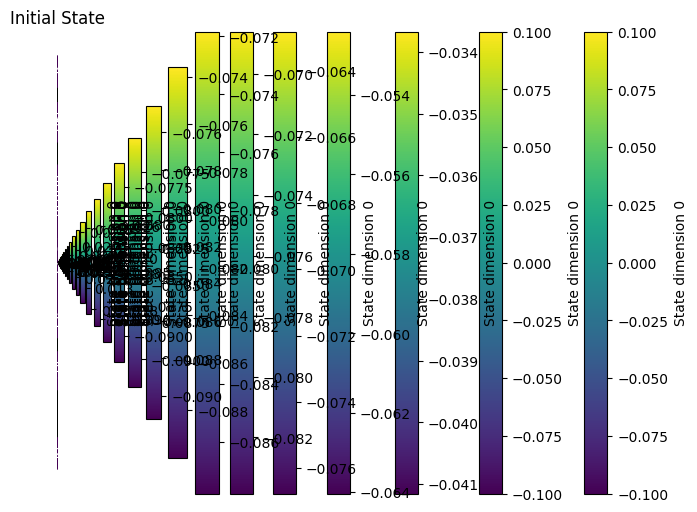

In [12]:
def visualize_diffusion_during_inference(model, graph, node_features):
    """
    Visualize the diffusion of information during model inference.
    
    Args:
        model: Trained GNN model
        graph: NetworkX graph
        node_features: Dictionary of node features
        
    Returns:
        Animation of diffusion process
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Convert to PyTorch tensors
    data = convert_networkx_to_pytorch(graph, node_features, None, device)
    
    # Forward pass with state tracking
    with torch.no_grad():
        outputs, state_history = model(
            data['node_features'], data['edge_index'], 
            return_states=True
        )
    
    # Convert state history to numpy for visualization
    state_history_cpu = [states.cpu().numpy() for states in state_history]
    
    # Convert to dictionary format for visualization functions
    state_dict_history = []
    for states in state_history_cpu:
        state_dict = {node: torch.tensor(states[node]) for node in range(len(graph.nodes()))}
        state_dict_history.append(state_dict)
    
    # Create animation
    from matplotlib.animation import FuncAnimation
    
    fig, ax = plt.subplots(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    
    # Initialize plot
    def init():
        ax.clear()
        visualize_diffusion_step(graph, state_dict_history[0], pos, dim_idx=0, ax=ax)
        ax.set_title("Initial State")
        ax.axis('off')
        return ax,
    
    # Update function for animation
    def update(frame):
        ax.clear()
        visualize_diffusion_step(graph, state_dict_history[frame], pos, dim_idx=0, ax=ax)
        ax.set_title(f"Iteration {frame}")
        ax.axis('off')
        return ax,
    
    # Create animation
    anim = FuncAnimation(
        fig, update, frames=len(state_dict_history), init_func=init,
        interval=500, blit=False
    )
    
    return anim

# Visualize diffusion on a test graph
test_graph = test_graphs[0]
test_features = test_node_features[0]

anim = visualize_diffusion_during_inference(model, test_graph, test_features)
from IPython.display import HTML
HTML(anim.to_jshtml())

## 6. Analyzing the Learned Transition Function

Finally, let's analyze the properties of the transition function that our model has learned:

Average contraction ratio: 0.5562
All ratios: [0.5561942308157886, 0.5561942076543088]


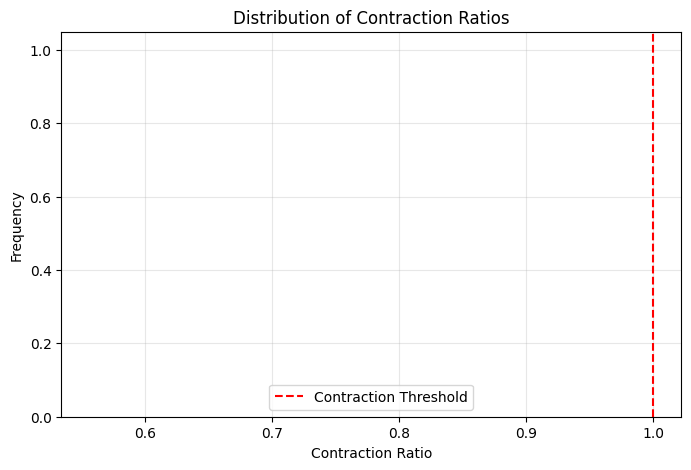

In [10]:
def analyze_learned_transition_function(model, graph, node_features):
    """
    Analyze the contraction property of the learned transition function.
    
    Args:
        model: Trained GNN model
        graph: NetworkX graph
        node_features: Dictionary of node features
        
    Returns:
        Contraction ratio
    """
    device = next(model.parameters()).device
    
    # Convert to PyTorch tensors
    data = convert_networkx_to_pytorch(graph, node_features, None, device)
    
    # Generate two random initial states
    num_nodes = data['node_features'].size(0)
    state_dim = model.state_dim
    
    states_1 = torch.randn(num_nodes, state_dim, device=device)
    states_2 = torch.randn(num_nodes, state_dim, device=device)
    
    # Compute initial distance
    initial_distance = torch.norm(states_1 - states_2).item()
    
    # Apply first GNN layer once
    with torch.no_grad():
        layer = model.layers[0]
        new_states_1 = layer(data['node_features'], states_1, data['edge_index'])
        new_states_2 = layer(data['node_features'], states_2, data['edge_index'])
    
    # Compute new distance
    new_distance = torch.norm(new_states_1 - new_states_2).item()
    
    # Compute contraction ratio
    contraction_ratio = new_distance / initial_distance
    
    return contraction_ratio

# Analyze contraction property for multiple graphs
contraction_ratios = [
    analyze_learned_transition_function(model, graph, node_features)
    for graph, node_features in zip(test_graphs, test_node_features)
]

print(f"Average contraction ratio: {sum(contraction_ratios) / len(contraction_ratios):.4f}")
print(f"All ratios: {contraction_ratios}")

plt.figure(figsize=(8, 5))
plt.hist(contraction_ratios, bins=10, alpha=0.7)
plt.axvline(x=1.0, color='r', linestyle='--', label='Contraction Threshold')
plt.title('Distribution of Contraction Ratios')
plt.xlabel('Contraction Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Conclusion

In this notebook, we've implemented a trainable GNN model and demonstrated:

1. How to parameterize the transition and output functions
2. How to train a GNN for node classification
3. How to visualize the diffusion of information during inference
4. How to analyze the contraction property of the learned transition function

The contraction property is crucial for ensuring that the GNN's iterative state updates converge to a unique fixed point. Our implementation successfully maintains this property by:
- Initializing weights to small values
- Using residual connections with a learned coefficient
- Applying appropriate normalization during message aggregation